### Constructing Brain-Like Space and Visualization

Discovered 9 categories: ['LLM', 'LLM-RoPE', 'LMM-language', 'LMM-language-RoPE', 'LMM-vision', 'LMM-vision-RoPE', 'ViT', 'ViT-Variants-global-semantic', 'ViT-Variants-local-reconstructive']
Discovered 151 JSON model files


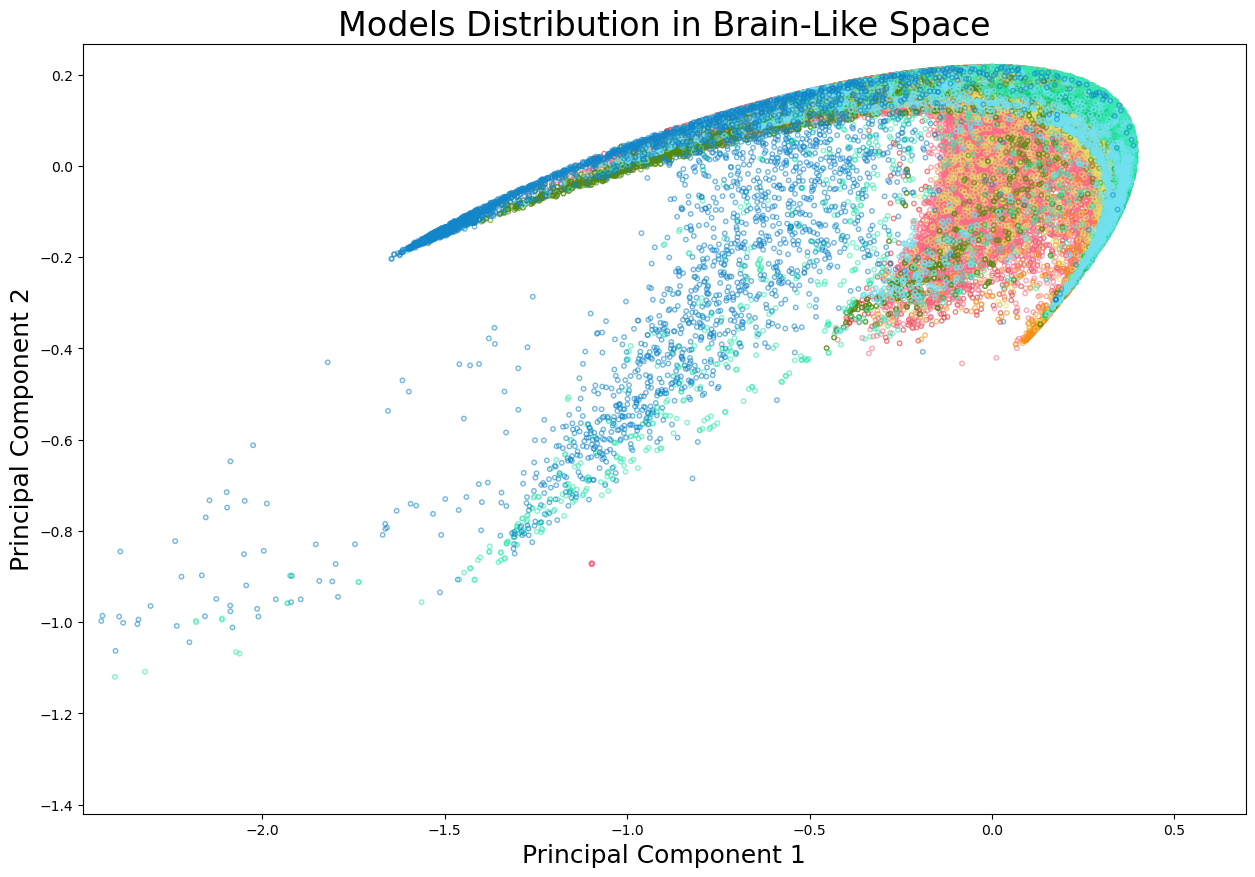

In [1]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Tuple, Optional

def discover_model_files(data_dir: str) -> Tuple[Dict[str, str], List[str], List[str]]:
    """
    Discover model files from specified directory and determine categories based on subfolders
    """
    model_categories = {}
    all_model_paths = []
    categories = []
    
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue
            
        categories.append(category)
        
        # Traverse all files in category folder, keep only JSON files
        for filename in os.listdir(category_path):
            if filename.lower().endswith('.json'):
                file_path = os.path.join(category_path, filename)
                if os.path.isfile(file_path):
                    model_categories[file_path] = category
                    all_model_paths.append(file_path)
    
    return model_categories, all_model_paths, categories

def extract_brain_like_head_embeddings(
    model_data_path,
    bio_path,
    graph_metrics=None,
    standardize=True
):
    """
    Extract brain-like embeddings for attention heads based on graph metric similarity
    
    This function computes cosine similarity between biological brain network metrics
    and transformer attention head graph metrics to create brain-like embeddings.
    
    Args:
        model_data_path: Path to JSON file containing model attention head graph metrics
        bio_path: Path to JSON file containing biological brain network metrics
        graph_metrics: List of graph metrics to use for comparison (default: common metrics)
        standardize: Whether to standardize metrics before comparison
        
    Returns:
        head_embeddings: Array of similarity vectors for each attention head [num_heads, n_subnets]
        head_names: List of head identifiers (e.g., 'L0_H0')
        subnet_names: List of biological subnet names
    """
    # Default graph metrics for comparison
    if graph_metrics is None:
        graph_metrics = ['clustering', 'modularity', 'global_efficiency', 'average_shortest_path', 'degree_std']

    # Load biological and model data
    with open(bio_path, 'r') as f:
        bio_data = json.load(f)

    with open(model_data_path, 'r') as f:
        model_data = json.load(f)

    subnet_names = list(bio_data.keys())
    
    # Extract and standardize biological vectors
    bio_vectors = np.array([
        [bio_data[subnet][m] for m in graph_metrics]
        for subnet in subnet_names
    ])  # Shape: [n_subnets, num_metrics]
    
    if standardize:
        bio_vectors_std = np.zeros_like(bio_vectors, dtype=np.float64)
        for i, vec in enumerate(bio_vectors):
            mean = np.mean(vec)
            std = np.std(vec)
            if std > 1e-8:  # Avoid division by zero
                bio_vectors_std[i] = (vec - mean) / std
            else:
                bio_vectors_std[i] = vec - mean
    else:
        bio_vectors_std = bio_vectors

    head_names = []
    head_embeddings = []

    # Process each layer in the model
    for layer in model_data:
        head_metrics_list = model_data[layer]
        
        # Extract and standardize attention head vectors for current layer
        layer_vectors = np.array([
            [head_metrics[m] for m in graph_metrics]
            for head_metrics in head_metrics_list
        ])  # Shape: [n_heads, num_metrics]
        
        if standardize:
            layer_vectors_std = np.zeros_like(layer_vectors, dtype=np.float64)
            for i, vec in enumerate(layer_vectors):
                mean = np.mean(vec)
                std = np.std(vec)
                if std > 1e-8:  # Avoid division by zero
                    layer_vectors_std[i] = (vec - mean) / std
                else:
                    layer_vectors_std[i] = vec - mean
        else:
            layer_vectors_std = layer_vectors

        # Compute cosine similarity between biological networks and attention heads
        similarities = cosine_similarity(bio_vectors_std, layer_vectors_std)  # Shape: [n_subnets, n_heads]

        # Store results for each attention head
        for i in range(similarities.shape[1]):
            head_embeddings.append(similarities[:, i])  # Similarity vector for each head with all subnets
            head_names.append(f'L{layer}_H{i}')

    head_embeddings = np.array(head_embeddings)  # Final shape: [num_heads_total, n_subnets]
    return head_embeddings, head_names, subnet_names

def perform_pca_projection(
    model_paths: List[str],
    bio_path: str,
    model_categories: Dict[str, str],
    graph_metrics: Optional[List[str]] = None,
    n_components: int = 2,
    standardize: bool = True,
    save_path: Optional[str] = None
) -> Tuple[np.ndarray, List[str], Dict[str, np.ndarray], plt.Figure]:
    """
    Perform PCA dimensionality reduction and project all models to the same space
    
    Parameters:
        model_paths: List of paths to all model files
        bio_path: Path to biological data file
        model_categories: Dictionary mapping model paths to category names {model_path: category_name}
        graph_metrics: List of graph metrics to use
        n_components: Number of dimensions after PCA reduction
        standardize: Whether to standardize features
        save_path: Path to save visualization image, if None then don't save
    
    Returns:
        all_embeddings_pca: PCA results for all models
        all_embedding_names: List of embedding names for all models
        model_pca_results: PCA results grouped by model path {model_path: projected_embeddings}
        fig: Visualization figure object
    """
    # Verify all models are JSON files
    for path in model_paths:
        if not path.lower().endswith('.json'):
            raise ValueError(f"Model file {path} is not a JSON file")
    
    # Extract embeddings for all models and record correspondences
    all_embeddings = []
    all_embedding_names = []
    embedding_model_mapping = []  # Record which model path each embedding belongs to
    
    for model_path in model_paths:
        embeddings, embedding_names, subnet_names = extract_brain_like_head_embeddings(
            model_path, bio_path, graph_metrics, standardize
        )
        
        # Check if embeddings contain NaN values
        if np.isnan(embeddings).any():
            print(f"[Final Check] Model {os.path.basename(model_path)} has {np.isnan(embeddings).sum()} NaN values in embeddings!")
            embeddings = np.nan_to_num(embeddings)
        
        # Record embeddings, names and corresponding models
        all_embeddings.append(embeddings)
        all_embedding_names.extend(embedding_names)
        embedding_model_mapping.extend([model_path] * len(embeddings))
    
    # Combine all embeddings and perform PCA
    all_embeddings = np.vstack(all_embeddings)
    pca = PCA(n_components=n_components)
    all_embeddings_pca = pca.fit_transform(all_embeddings)

    # ------------------- Calculate global PCA result extremes (for fixed scale) -------------------
    # Get global min/max for x-axis (first principal component), add 0.1 margin to avoid edge points
    global_x_min = all_embeddings_pca[:, 0].min() - 0.05
    global_x_max = all_embeddings_pca[:, 0].max() + 0.3
    # Get global min/max for y-axis (second principal component)
    global_y_min = all_embeddings_pca[:, 1].min() - 0.3
    global_y_max = all_embeddings_pca[:, 1].max() + 0.05

    # Group PCA results by model path
    model_pca_results = {}
    for model_path in model_paths:
        # Find indices of all embeddings for this model
        indices = [i for i, mp in enumerate(embedding_model_mapping) if mp == model_path]
        model_pca_results[model_path] = all_embeddings_pca[indices]
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 10))

    # Custom set of soft but distinguishable colors (can be adjusted based on number of categories)
    CUSTOM_COLORS = [
        "#DD3131",  # 1lan
        "#FA6D84",  # 2lan-r
        "#F78F18",  # 3lan-m
        "#E2E06A",  # 3lan-m-r
        "#518A0F",  # 4vis-m
        "#11CE76",  # 4vis-m-r
        "#34E9B2",  # 5vit
        "#71E1F0",  # 6vit-g
        "#1286C9",  # 7vit-l
    ]

    unique_categories = sorted(set(model_categories.values()))
    # If number of categories exceeds custom colors, cycle through them
    colors = [CUSTOM_COLORS[i % len(CUSTOM_COLORS)] for i in range(len(unique_categories))]
    color_map = {cat: colors[i] for i, cat in enumerate(unique_categories)}

    # Plot all models
    for model_path, pca_result in model_pca_results.items():
        category = model_categories.get(model_path, "Unknown")
        color = color_map.get(category, "gray")  # "Unknown" fixed as gray
        model_name = os.path.basename(model_path)
        cat_folder = os.path.basename(os.path.dirname(model_path))
        
        # Plot invisible solid points for legend (do not remove)
        ax.scatter(
            [], [],  # Empty coordinates, not displayed on plot
            c=color,   
            s=20,
            label=f"{model_name} ({cat_folder})",
            alpha=0.6,
            marker='o',
        )
        # Plot hollow circles for actual data points
        ax.scatter(
            pca_result[:, 0], 
            pca_result[:, 1],
            facecolors='none',  # Hollow
            edgecolors=color,   # Outline color
            s=10,
            alpha=0.6,
            marker='o',
            label='_nolegend_'  # Avoid duplicate legend entries
        )

    # ------------------- Fixed axis range (based on global extremes) -------------------
    ax.set_xlim(global_x_min, global_x_max)  # x-axis scale fixed to global range
    ax.set_ylim(global_y_min, global_y_max)  # y-axis scale fixed to global range
# --------------------------------------------------------------------------------
        
    # Add legend and title
    ax.set_title('Models Distribution in Brain-Like Space', fontsize=24)
    ax.set_xlabel(f'Principal Component 1', fontsize=18)
    ax.set_ylabel(f'Principal Component 2', fontsize=18)
    
    # # Adjust legend position (keep original code logic)
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    
    # # Add grid
    # ax.grid(True, linestyle='--', alpha=0.6)

    # Save image (if path specified)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return all_embeddings_pca, all_embedding_names, model_pca_results, fig


# Example usage

# Configure paths
data_dir = "./model-result"  # Root directory containing all model categories
bio_path = "./braingraph-new-metric.json"

# Automatically discover model files and categories
model_categories, all_model_paths, categories = discover_model_files(data_dir)

print(f"Discovered {len(categories)} categories: {categories}")
print(f"Discovered {len(all_model_paths)} JSON model files")

# Perform PCA and projection (process all models together, maintain individual model display)
all_pca, all_names, model_results, fig = perform_pca_projection(
    model_paths=all_model_paths,
    bio_path=bio_path,
    model_categories=model_categories,
    n_components=2,
    standardize=True,
    save_path=None
)

plt.show()

### Calculating Brain-Likeness Scores

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def extract_brain_like_head_embeddings(
    model_data_path,
    bio_path,
    graph_metrics=None,
    standardize=True
):
    """
    Extract brain-like embeddings for attention heads based on graph metric similarity
    
    This function computes cosine similarity between biological brain network metrics
    and transformer attention head graph metrics to create brain-like embeddings.
    
    Args:
        model_data_path: Path to JSON file containing model attention head graph metrics
        bio_path: Path to JSON file containing biological brain network metrics
        graph_metrics: List of graph metrics to use for comparison (default: common metrics)
        standardize: Whether to standardize metrics before comparison
        
    Returns:
        head_embeddings: Array of similarity vectors for each attention head [num_heads, n_subnets]
        head_names: List of head identifiers (e.g., 'L0_H0')
        subnet_names: List of biological subnet names
    """
    # Default graph metrics for comparison
    if graph_metrics is None:
        graph_metrics = ['clustering', 'modularity', 'global_efficiency', 'average_shortest_path', 'degree_std']

    # Load biological and model data
    with open(bio_path, 'r') as f:
        bio_data = json.load(f)

    with open(model_data_path, 'r') as f:
        model_data = json.load(f)

    subnet_names = list(bio_data.keys())
    
    # Extract and standardize biological vectors
    bio_vectors = np.array([
        [bio_data[subnet][m] for m in graph_metrics]
        for subnet in subnet_names
    ])  # Shape: [n_subnets, num_metrics]
    
    if standardize:
        bio_vectors_std = np.zeros_like(bio_vectors, dtype=np.float64)
        for i, vec in enumerate(bio_vectors):
            mean = np.mean(vec)
            std = np.std(vec)
            if std > 1e-8:  # Avoid division by zero
                bio_vectors_std[i] = (vec - mean) / std
            else:
                bio_vectors_std[i] = vec - mean
    else:
        bio_vectors_std = bio_vectors

    head_names = []
    head_embeddings = []

    # Process each layer in the model
    for layer in model_data:
        head_metrics_list = model_data[layer]
        
        # Extract and standardize attention head vectors for current layer
        layer_vectors = np.array([
            [head_metrics[m] for m in graph_metrics]
            for head_metrics in head_metrics_list
        ])  # Shape: [n_heads, num_metrics]
        
        if standardize:
            layer_vectors_std = np.zeros_like(layer_vectors, dtype=np.float64)
            for i, vec in enumerate(layer_vectors):
                mean = np.mean(vec)
                std = np.std(vec)
                if std > 1e-8:  # Avoid division by zero
                    layer_vectors_std[i] = (vec - mean) / std
                else:
                    layer_vectors_std[i] = vec - mean
        else:
            layer_vectors_std = layer_vectors

        # Compute cosine similarity between biological networks and attention heads
        similarities = cosine_similarity(bio_vectors_std, layer_vectors_std)  # Shape: [n_subnets, n_heads]

        # Store results for each attention head
        for i in range(similarities.shape[1]):
            head_embeddings.append(similarities[:, i])  # Similarity vector for each head with all subnets
            head_names.append(f'L{layer}_H{i}')

    head_embeddings = np.array(head_embeddings)  # Final shape: [num_heads_total, n_subnets]
    return head_embeddings, head_names, subnet_names

def summarize_model_projection_to_pc1(
        model_paths,
        bio_path,
        graph_metrics,
        pca: PCA,          
        save_path=None):
    """
    Projects head embedding vectors from multiple models onto the first principal component
    of a precomputed PCA space and calculates summary statistics including total projection
    scores and positive projection scores for each model.
    
    This function performs the following steps:
    1. Collects projections from all models to determine global value range
    2. For each model:
       - Extracts head embeddings and projects them onto PC1
       - Plots a histogram of these projections
       - Calculates total and positive-only projection sums
    3. Saves summary statistics to an Excel file if specified
    
    Parameters:
        model_paths (dict): Dictionary mapping model names to their file paths
        bio_path (str): File path to biological data (brain network results)
        graph_metrics (list): List of graph metrics to use in embedding extraction
        pca (PCA): Pre-fitted PCA object from scikit-learn
        save_path (str, optional): Path to save the summary Excel file. Defaults to None.
    
    Returns:
        None: Results are displayed as plots and optionally saved to Excel
    """
    summary = []
    custom_hist_color = '#c2c2c2'
    fixed_figsize = (5, 4)

    all_projections = []

    # ---------- 1. Collect global range for consistent plotting ----------
    for model_path in model_paths.values():
        # Extract embeddings with standardization
        head_embeddings, *_ = extract_brain_like_head_embeddings(
            model_path, bio_path, graph_metrics, standardize=True)
        head_embeddings = np.array(head_embeddings)
        
        # Center embeddings using PCA mean and project onto first component
        centered = head_embeddings - pca.mean_
        proj = centered @ pca.components_[0]
        all_projections.extend(proj)

    # Calculate global min/max with margin for consistent x-axis across plots
    global_min, global_max = min(all_projections), max(all_projections)
    x_margin = (global_max - global_min) * 0.1
    xlim = (global_min - x_margin, global_max + x_margin)

    # ---------- 2. Generate plots and statistics for each model ----------
    for model_name, model_path in model_paths.items():
        # Extract and process embeddings for current model
        head_embeddings, *_ = extract_brain_like_head_embeddings(
            model_path, bio_path, graph_metrics, standardize=True)
        head_embeddings = np.array(head_embeddings)
        centered = head_embeddings - pca.mean_
        projections = centered @ pca.components_[0]

        # Create and configure histogram
        plt.figure(figsize=fixed_figsize)
        plt.hist(projections, bins=30, color=custom_hist_color,
                 edgecolor='white', alpha=0.8)
        plt.xlim(xlim)
        plt.title(model_name, fontsize=18)
        plt.xlabel('PC1 projection', fontsize=14)
        plt.ylabel('Number of heads', fontsize=14)
        plt.axvline(0, color='#f38787', ls='--')  # Vertical line at zero
        plt.tight_layout()
        plt.show()

        # Calculate and store summary statistics
        summary.append({
            'model': model_name,
            'total_projection': projections.sum(),
            'positive_projection': projections[projections > 0].sum()
        })

    # Save results if path is provided
    if save_path:
        pd.DataFrame(summary).to_excel(save_path, index=False)
        print(f'Successfully saved: {save_path}')


# Example usage
all_model_paths = "./model-result"
all_embeddings = []
for model_path in all_model_paths:
        embeddings, embedding_names, subnet_names = extract_brain_like_head_embeddings(
            model_path, bio_path
        )
        all_embeddings.append(embeddings)
# Combine all embeddings and perform PCA
all_embeddings = np.vstack(all_embeddings)
pca = PCA(n_components=2)
principal_coords = pca.fit_transform(all_embeddings)



# Dictionary mapping model names to their result paths
graph_metrics = ['clustering', 'modularity', 'global_efficiency', 'average_shortest_path', 'degree_std']
model_paths = {
    'model name': 'your single model result path'
    # Add more models as needed
}

# Execute the projection summary analysis
summarize_model_projection_to_pc1(
    model_paths=model_paths,
    bio_path="./brainnetwork-result.json",
    graph_metrics=graph_metrics,
    pca=pca,
    save_path='brain-likeness score.xlsx'
)
